<a href="https://colab.research.google.com/github/chaxx176/World-Happiness-Report-2021/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 데이터 불러오기
import pandas as pd
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
df= pd.read_csv('/content/drive/MyDrive/ColabNotebooks/happy_0817.csv', header=0)
ndf=df.sample(frac=1,random_state=4).reset_index(drop=True)  

from sklearn.preprocessing import MinMaxScaler

# 정규화
x= ndf[['log_gdp', 'social', 'life_exp', 'freedom','generosity', 'corruption', 
       'schooling', 'alcohol', 'suicide','obesity', 'birth', 'mental']]
xnor = MinMaxScaler().fit_transform(x)
ndfnor = pd.DataFrame(xnor)
ndfnor.columns = ['log_gdp', 'social', 'life_exp', 'freedom', 'generosity', 'corruption', 'schooling', 'alcohol',
                     'suicide','obesity', 'birth', 'mental']

# country 원핫인코딩
ndf_country = pd.get_dummies(ndf['country'])

# 정규화 안한 컬럼, 원핫인코딩 컬럼 dfnor에 추가
ndfnor[['HS','year','country','country_num','continent']]= ndf[['HS','year','country','country_num','continent']]
ndfnor = pd.concat([ndfnor, ndf_country], axis=1)
ndfnor

# X,y 데이터 분리
X_data = ndfnor.drop(['HS','year','country','country_num','continent'], axis = 1)
y = ndfnor[['HS']]

# Train, Test 데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_data, y, test_size=0.3, random_state=4)
print(X_train.shape, y_train.shape) # (1316, 165) (1316, 1)
print(X_test.shape, y_test.shape) # (565, 165) (565, 1)


(1316, 165) (1316, 1)
(565, 165) (565, 1)


처리중인 폴드 # 0
Epoch 1/500
8/8 [==============================] - 1s 46ms/step - loss: 27.3336 - mae: 5.1104 - val_loss: 24.0154 - val_mae: 4.7892
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 20.4773 - mae: 4.3973 - val_loss: 15.2907 - val_mae: 3.7905
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 10.0449 - mae: 2.9847 - val_loss: 3.4412 - val_mae: 1.6745
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5080 - mae: 0.9894 - val_loss: 1.9160 - val_mae: 1.2294
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 1.9639 - mae: 1.2252 - val_loss: 0.5738 - val_mae: 0.6303
Epoch 6/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5997 - mae: 0.6159 - val_loss: 0.8055 - val_mae: 0.7174
Epoch 7/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7063 - mae: 0.6727 - val_loss: 0.4180 - val_mae: 0.5065
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3847 -

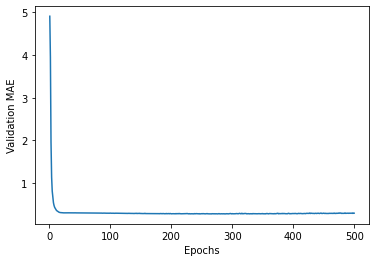

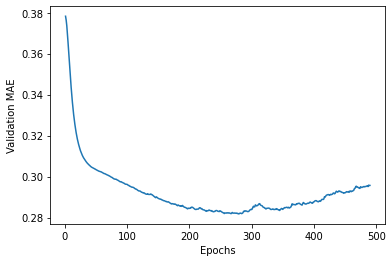

In [8]:
# 모델 구성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model(): 
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 에포크 500
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
    
    #케라스 모델 구성(컴파일 포함)
    model = build_model()
    #모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않음)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=128)
    #검증 세트로 모델 평가
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
    
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]    

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [9]:
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)
test_mae_score


18/18 [==============================] - 0s 3ms/step - loss: 0.1674 - mae: 0.2962


0.2961641848087311